# Цель работы

Проанализировать данные по прохождению студентами тестов на образовательной платформе. Сосредоточиться на обработке и подготовке данных.

- Данные находятся в 3 файлах:
    1.  train.csv
    2.  lectures.csv
    3.  questions.csv

### Структура файлов
#### Структура train.csv:
- **row_id**: (int64) ID строки.
- **timestamp**: (int64) время в миллисекундах между этим взаимодействием пользователя и первым завершённым событием этого пользователя.
- **user_id**: (int32) ID пользователя.
- **content_id**: (int16) ID содержимого, с которым взаимодействовал пользователь.
- **content_type_id**: (int8) 0 — если это вопрос, представленный пользователю, 1 — если это лекция, просмотренная пользователем.
- **task_container_id**: (int16) ID для набора вопросов или лекций. Например, пользователь может увидеть три вопроса подряд перед тем, как ему покажут объяснения. Эти три вопроса будут иметь один и тот же `task_container_id`.
- **user_answer**: (int8) ответ пользователя на вопрос, если он был дан. -1 означает отсутствие ответа, применимо к лекциям.
- **answered_correctly**: (int8) указывает, ответил ли пользователь правильно. -1 означает отсутствие ответа, применимо к лекциям.
- **prior_question_elapsed_time**: (float32) среднее время в миллисекундах, которое пользователь потратил на ответ на каждый вопрос из предыдущего набора вопросов, не учитывая лекции между ними. Отсутствует для первого набора вопросов или лекции у пользователя. Обратите внимание, что это среднее время, затраченное пользователем на решение каждого вопроса из предыдущего набора.
- **prior_question_had_explanation**: (bool) показывает, видел ли пользователь объяснение и правильный ответ(ы) после завершения предыдущего набора вопросов, не считая лекции между ними. Значение применяется ко всему набору вопросов, и отсутствует для первого набора вопросов или лекции пользователя. Обычно первые несколько вопросов, которые видит пользователь, являются частью диагностического теста, в котором не предоставлялась обратная связь.
    
#### Структура questions.csv:
- **question_id**: внешний ключ для столбца `content_id` в тренировочных/тестовых данных, когда тип содержимого — вопрос (0).
- **bundle_id**: код, по которому вопросы группируются вместе.
- **correct_answer**: правильный ответ на вопрос. Можно сравнить с `user_answer` в тренировочных данных, чтобы проверить, был ли пользователь прав.
- **part**: соответствующая часть теста TOEIC.
- **tags**: один или несколько детализированных кодов тегов для вопроса. Значение тегов не предоставляется, но эти коды достаточно для кластеризации вопросов.

#### Структура lectures.csv:
- **lecture_id**: внешний ключ для столбца `content_id` в тренировочных/тестовых данных, когда тип содержимого — лекция (1).
- **part**: код категории верхнего уровня для лекции.
- **tag**: код тега для лекции. Значение тегов не предоставляется, но эти коды достаточно для кластеризации лекций.
- **type_of**: краткое описание основной цели лекции.

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
train_df = pd.read_csv('/Users/danilapertsev/Desktop/ДЗ3/train.csv')
questions_df = pd.read_csv('/Users/danilapertsev/Desktop/ДЗ3/questions.csv')
lectures_df = pd.read_csv('/Users/danilapertsev/Desktop/ДЗ3/lectures.csv')

## Получение первичной информации о файлах, пропусках и повторах.

In [132]:
sample_size = 0.15 * len(train_df)

#### Данные датасета слишком объемны, для анализа библиотекой pandas можно взять 15% генеральной совокупности, но мы не можем взять случайные 15%, так как данные о студентах идут в порядке очереди. Поэтому было принято решение брать первые 15% выборки.

In [134]:
train_df_15 = train_df.head(round(sample_size))

In [135]:
train_df_15 = train_df_15.set_index('row_id')

In [136]:
train_df_15.shape

(15184550, 9)

In [168]:
train_df_15.head()

,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
row_id,,,,,,,,,
0,0,115,5692,0,1,3,1,NaN,NaN
1,56943,115,5716,0,2,2,1,37000.0,False
2,118363,115,128,0,0,0,1,55000.0,False
3,131167,115,7860,0,3,0,1,19000.0,False
4,137965,115,7922,0,4,1,1,11000.0,False


In [137]:
train_df_15 = train_df_15.drop_duplicates()

In [138]:
train_df_15.shape

(15184515, 9)

In [139]:
train_df_15.isna().sum()

timestamp                              0
user_id                                0
content_id                             0
content_type_id                        0
task_container_id                      0
user_answer                            0
answered_correctly                     0
prior_question_elapsed_time       356792
prior_question_had_explanation     59395
dtype: int64

In [158]:
train_df_15.loc[train_df_15['content_type_id'] == 1] 

,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
row_id,,,,,,,,,
89,653762,2746,6808,1,14,-1,-1,NaN,False
117,10183847,5382,16736,1,21,-1,-1,NaN,False
212,1424348597,5382,30207,1,104,-1,-1,NaN,False
216,1425557777,5382,18545,1,121,-1,-1,NaN,False
295,405813029,8623,10540,1,59,-1,-1,NaN,False
...,...,...,...,...,...,...,...,...,...
15184171,23752484066,326410713,13471,1,4095,-1,-1,NaN,False
15184211,33757480225,326410713,22390,1,4115,-1,-1,NaN,False
15184461,881295,326413470,15430,1,17,-1,-1,NaN,False


#### Необходимо проверить большое количество пропусков в столбце prior_question_elapsed_time, проверим описание,что лекционный материал просто не подлежал тестированию. 

In [140]:
train_df_15['user_answer'].value_counts()

user_answer
 0    4228923
 1    4040233
 3    3914437
 2    2703525
-1     297397
Name: count, dtype: int64

#### Проверим какой процент от пропусков содержал в себе лекционный материал

In [141]:
print(train_df_15.loc[train_df_15['content_type_id'] == 1].shape[0]/train_df_15.loc[train_df_15['prior_question_elapsed_time'].isna() == True].shape[0]) 

0.8335304603242225


#### Гипотеза почти подтверждена, но надо глянуть что происходит с остальными 17%

In [155]:
train_df_15[(train_df_15['content_type_id'] == 0) & (train_df_15['prior_question_elapsed_time'].isna() == True)]

,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
row_id,,,,,,,,,
0,0,115,5692,0,1,3,1,NaN,NaN
46,0,124,7900,0,0,0,1,NaN,NaN
76,0,2746,5273,0,0,1,0,NaN,NaN
96,0,5382,5000,0,0,0,1,NaN,NaN
224,0,8623,3915,0,0,3,1,NaN,NaN
...,...,...,...,...,...,...,...,...,...
15178884,0,326392452,128,0,0,0,1,NaN,NaN
15179004,0,326410713,7900,0,0,2,0,NaN,NaN
15184405,0,326412948,7900,0,0,0,1,NaN,NaN


In [179]:
train_df_15[(train_df_15['prior_question_elapsed_time'].isna() == True) & (train_df_15['timestamp'] != 0) & (train_df_15['content_type_id'] == 0)]

,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
row_id,,,,,,,,,
1631931,12231,34683777,4784,0,1,1,1,NaN,NaN
7791632,10632,169503292,6120,0,1,1,1,NaN,NaN
8131664,160173,177104356,4818,0,1,1,1,NaN,NaN
9604622,73906,209367010,4533,0,2,0,1,NaN,NaN
11238194,97682,243667830,8643,0,1,3,1,NaN,NaN
11277747,23913,244422312,6291,0,2,2,1,NaN,NaN


In [182]:
train_df_15[train_df_15['user_id'] == 34683777].head(3)

,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
row_id,,,,,,,,,
1631930,0,34683777,24697,1,0,-1,-1,NaN,False
1631931,12231,34683777,4784,0,1,1,1,NaN,NaN
1631932,29782,34683777,4472,0,2,3,1,7000.0,True


#### По итогу проверки можно сделать вывод, что в столбце prior_question_elapsed_time пропуски возникают в двух случаях, либо данная строка отвечает за лекционный материал, либо это первый вопрос у студента(он может идти после первой лекции). Пропуски в столбце prior_question_had_explanation появляются когда это первый вопрос у студента(он может идти после первой лекции).

#### Теперь необходимо данные пропуски обработать, в случае  prior_question_elapsed_time предлагаю поставть 0.0, а в случае prior_question_had_explanation поставить False, так как обратной связи после леции не было. Чтоб не было путаницы, можно ввести дополнительное поле first_question, отвечающее за то, является ли данный вопрос для студента первым.

In [184]:
train_df_15[train_df_15['prior_question_elapsed_time'] == 0.0].head(10)

,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
row_id,,,,,,,,,
20535,2912969748,275762,7964,0,141,2,0,0.0,True
20603,3247775151,275762,7898,0,208,1,0,0.0,True
24948,40688,457531,6116,0,11,2,0,0.0,False
45617,23975123,1214143,279,0,85,1,0,0.0,True
48013,4176303497,1272775,632,0,220,0,0,0.0,True
62919,967919346,1400354,6058,0,116,1,1,0.0,True
70376,178485,1524501,6116,0,11,0,0,0.0,False
70378,185828,1524501,6370,0,13,2,1,0.0,False
90280,18354194945,1989232,1755,0,300,3,0,0.0,True


In [185]:
train_df_15.loc[20530:20540]

,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
row_id,,,,,,,,,
20530,2912025974,275762,8511,0,137,2,1,14000.0,True
20531,2912146422,275762,6682,0,138,0,1,20000.0,True
20532,2912403525,275762,5700,0,139,0,1,20000.0,True
20533,2912598994,275762,4478,0,140,3,0,10000.0,True
20534,2912925246,275762,7898,0,114,2,1,20000.0,False
20535,2912969748,275762,7964,0,141,2,0,0.0,True
20536,2913236740,275762,10516,0,142,2,1,27000.0,False
20537,2913319787,275762,187,0,143,2,0,21000.0,True
20538,2913415341,275762,144,0,144,0,1,26000.0,True


#### Была выявлена аномалия, что у некоторых студентов prior_question_elapsed_time равен 0.0, что, исходя из условий поля, быть не может(только в тех случаях, которые описали выше).Возможно ошибка программы. Следуя логике, данные значения можно обработать, высчитат средний показатель студента и заменив им данные нули.

In [200]:
time_st_mean = train_df_15.groupby('user_id')['prior_question_elapsed_time'].median().round()

In [193]:
def replace_with_mean(row):
    if row['prior_question_elapsed_time'] == 0.0:
        return time_st_mean.get(row['user_id'], row['prior_question_elapsed_time'])
    else:
        return row['prior_question_elapsed_time']

In [194]:
train_df_15['prior_question_elapsed_time'] = train_df_15.apply(replace_with_mean, axis=1)

In [199]:
train_df_15[train_df_15['prior_question_elapsed_time'] == 0.0]

,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
row_id,,,,,,,,,
2252129,41684,47676259,6028,0,1,3,0,0.0,False
2252130,69276,47676259,244,0,2,0,0,0.0,False
2252131,93681,47676259,9261,0,3,0,1,0.0,False
2252132,114599,47676259,376,0,4,0,0,0.0,False
2252133,140462,47676259,5319,0,5,3,1,0.0,False
...,...,...,...,...,...,...,...,...,...
7044425,844467,153322292,5838,0,8,0,1,0.0,True
7044426,958681,153322292,5301,0,9,1,0,0.0,True
7044427,131247950,153322292,8503,0,10,0,0,0.0,True


####  Ддя данной группы студентов не получилось поставить среднее значение из за отстуствие каких либо значений, но поскольку у них тоже есть данные, поставим им медианное значение всей выборки.

In [201]:
median_value = train_df_15['prior_question_elapsed_time'].median()
train_df_15.loc[train_df_15['prior_question_elapsed_time'] == 0.0, 'prior_question_elapsed_time'] = median_value

####  Теперь можно обработать пропуски, поставим в столбце prior_question_elapsed_time 0, а в столбце prior_question_had_explanation False

In [203]:
train_df_15['prior_question_elapsed_time'] = train_df_15['prior_question_elapsed_time'].fillna(0)
train_df_15['prior_question_had_explanation'] = train_df_15['prior_question_had_explanation'].fillna( False)

#### Было удалено несколько повторов, обработаны пропуска в столбцах prior_question_elapsed_time,prior_question_had_explanation  

## Переходим к анализу датасета

In [206]:
train_df_15.head()

,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
row_id,,,,,,,,,
0,0,115,5692,0,1,3,1,0.0,False
1,56943,115,5716,0,2,2,1,37000.0,False
2,118363,115,128,0,0,0,1,55000.0,False
3,131167,115,7860,0,3,0,1,19000.0,False
4,137965,115,7922,0,4,1,1,11000.0,False


In [268]:
train_df_15.loc[train_df_15['content_type_id'] == 0]['answered_correctly'].mean()

0.6576619463888175

#### Показатель правильных ответов на вопросы находиться в районе 65%, что является неплохим результатом, продемонстрируем это на графике.

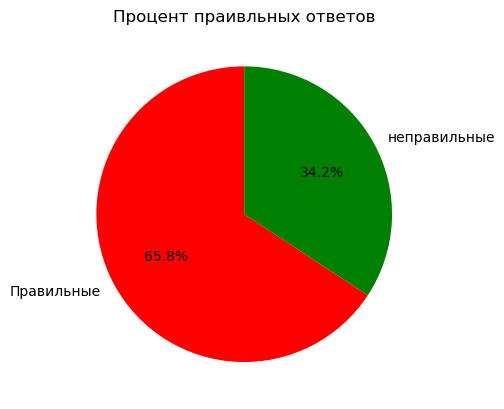

In [219]:
grade_counts = train_df_15.loc[train_df_15['content_type_id'] == 0]['answered_correctly'].value_counts()
plt.pie(grade_counts, labels=['Правильные', 'неправильные'], autopct='%1.1f%%', startangle=90, colors=['red', 'green'])
plt.title('Процент праивльных ответов')
plt.show()

#### Проверим гипотезу, что у студентов, которые смотрели лекции, количество правильных ответов выше.

In [242]:
students = train_df_15['user_id'].value_counts()

In [250]:
students = train_df_15.groupby('user_id')['content_type_id'].sum().sort_values()

In [251]:
students_nl = students[students == 0]

In [289]:
lectures_mean = train_df_15.loc[~(train_df_15['user_id'].isin(students_nl.index)) & (train_df_15['content_type_id'] == 0)]['answered_correctly'].mean()

In [290]:
n_lectures_mean = train_df_15.loc[(train_df_15['user_id'].isin(students_nl.index)) & (train_df_15['content_type_id'] == 0)]['answered_correctly'].mean()

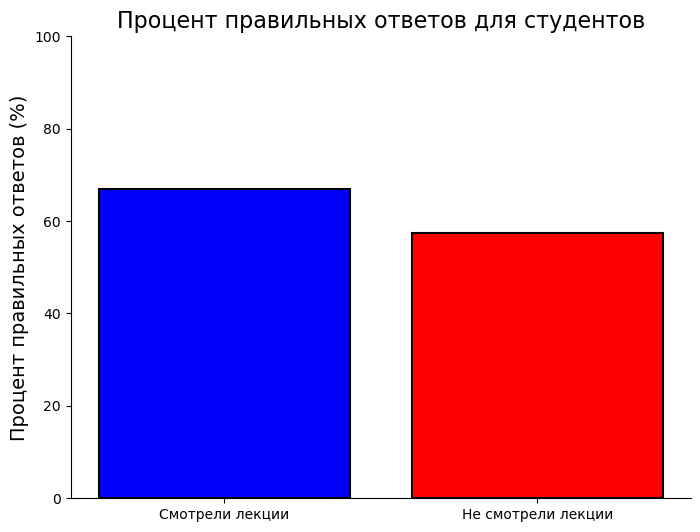

In [291]:
means = [lectures_mean * 100, n_lectures_mean * 100] 
labels = ['Смотрели лекции', 'Не смотрели лекции']
colors = ['blue', 'red'] 

plt.figure(figsize=(8, 6))
bars = plt.bar(labels, means, color=colors, edgecolor='black', linewidth=1.5)


# Настройки графика
plt.title('Процент правильных ответов для студентов', fontsize=16)
plt.ylabel('Процент правильных ответов (%)', fontsize=14)
plt.ylim(0, 100)  # Лимиты для оси Y от 0 до 100

sns.despine()
plt.show()

#### Гипотеза подтвердилась, также в процессе выяснилось, что студенты, смотрящие лекции, отвечали на больше количество вопросов

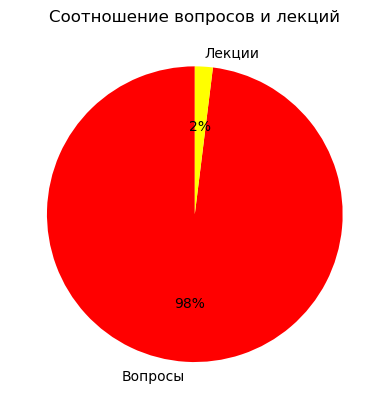

In [305]:
l_q_persent = train_df_15['content_type_id'].value_counts()
plt.pie(l_q_persent,labels=['Вопросы', 'Лекции'],  autopct='%1.f%%', startangle=90, colors=['red', 'yellow'])
plt.title('Соотношение вопросов и лекций')
plt.show()

#### Лекции составляют лишь 2% взаимодейстий студентов в системе

#### Для оценки временных параметров можно произвести перевод миллесекунд timestamp в секунды

In [309]:
train_df_15['timestamp'] = train_df_15['timestamp']/1000

#### Можно высчитать среднее количество действий студента

In [314]:
train_df_15.groupby('user_id')['timestamp'].count().describe()


count    59550.000000
mean       254.987657
std        738.009831
min          1.000000
25%         30.000000
50%         40.000000
75%        157.000000
max      15871.000000
Name: timestamp, dtype: float64

In [328]:
train_df_15.groupby('user_id')['timestamp'].count().median()

40.0

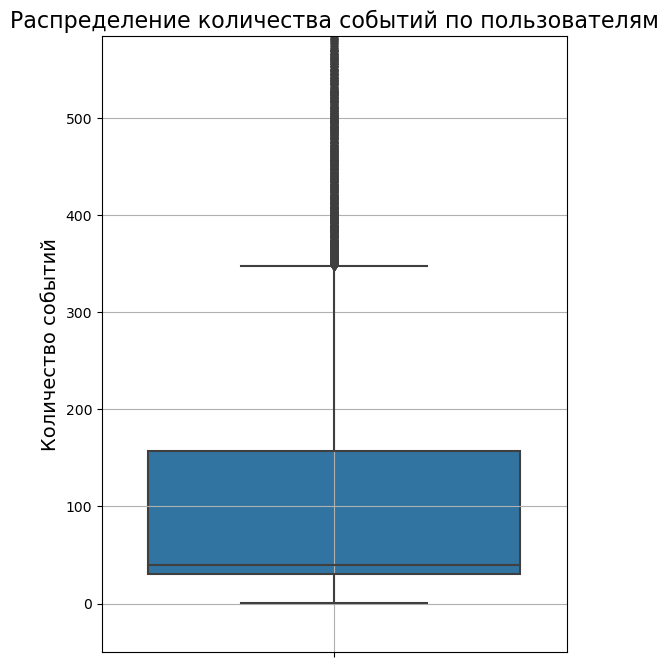

In [331]:
events = train_df_15.groupby('user_id')['timestamp'].count()
plt.figure(figsize=(6, 8))
sns.boxplot(y=events)
plt.grid(True)
# Настройки графика
plt.title('Распределение количества событий по пользователям', fontsize=16)
plt.xlabel('', fontsize=14)
plt.ylabel('Количество событий', fontsize=14)
plt.ylim(-50, event_counts.quantile(0.90)) 

# Показываем график
plt.show()

#### Как можно заметить, количество событий далеко от равномерного, и это еще мягко сказано, существует огромное количество выбросов справа, медиана достигает значения в 40 событий, но у некоторых пользователей события уходят и за 10000

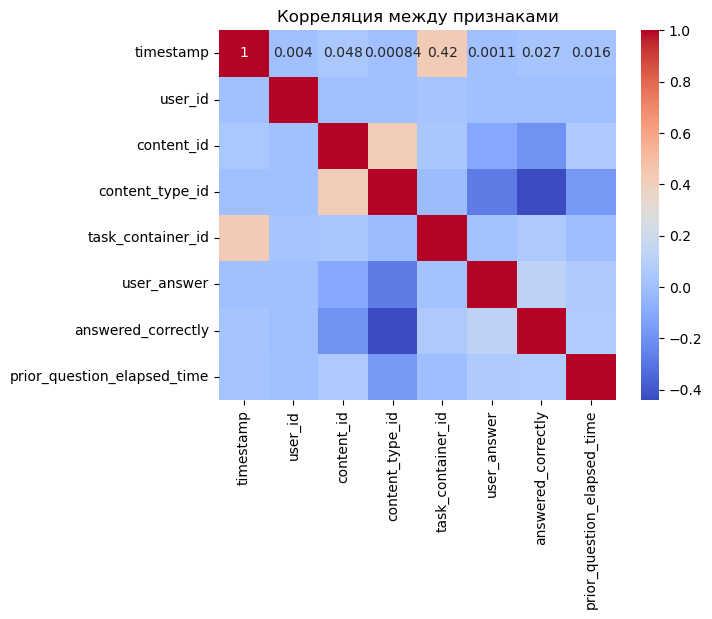

In [338]:
numeric_df = train_df_15.select_dtypes(include=['float64', 'int64'])

# Вычисление корреляционной матрицы
corr_matrix = numeric_df.corr()

# Построение heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Корреляция между признаками')
plt.show()

In [339]:
numeric_df.corr()

,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time
timestamp,1.000000,0.004011,0.048016,0.000843,0.424411,0.001054,0.026626,0.016426
user_id,0.004011,1.000000,0.003420,0.000735,0.022336,-0.000538,-0.000733,-0.003005
content_id,0.048016,0.003420,1.000000,0.416735,0.040808,-0.107846,-0.199774,0.049989
content_type_id,0.000843,0.000735,0.416735,1.000000,-0.019421,-0.281344,-0.439230,-0.174729
task_container_id,0.424411,0.022336,0.040808,-0.019421,1.000000,0.008605,0.058335,-0.007727
user_answer,0.001054,-0.000538,-0.107846,-0.281344,0.008605,1.000000,0.127642,0.064576
answered_correctly,0.026626,-0.000733,-0.199774,-0.439230,0.058335,0.127642,1.000000,0.069331
prior_question_elapsed_time,0.016426,-0.003005,0.049989,-0.174729,-0.007727,0.064576,0.069331,1.000000


#### Обращая внимание на матрицу корреляции, можно заметить, что числовые признаки слабо связаны между собой, можем лтшь вычленить обратную связь между признаками content_type_id и answered_correctly, и действительно, максимальное значение content_type_id 1 соотвествует лекции, и как мы уже выяснили, для всех лекций answered_correctly будет -1

#### Переход к таблице question

In [7]:
questions_df.shape

(13523, 5)

In [8]:
questions_df = questions_df.drop_duplicates()

In [9]:
questions_df.shape

(13523, 5)

In [10]:
questions_df.head(10)

,question_id,bundle_id,correct_answer,part,tags
0,0,0,0,1,51 131 162 38
1,1,1,1,1,131 36 81
2,2,2,0,1,131 101 162 92
3,3,3,0,1,131 149 162 29
4,4,4,3,1,131 5 162 38
5,5,5,2,1,131 149 162 81
6,6,6,2,1,10 94 162 92
7,7,7,0,1,61 110 162 29
8,8,8,3,1,131 13 162 92
9,9,9,3,1,10 164 81


In [11]:
questions_df = questions_df.set_index('question_id')

In [12]:
questions_df.isna().sum()

bundle_id         0
correct_answer    0
part              0
tags              1
dtype: int64

In [13]:
questions_df.loc[questions_df['tags'].isna()==True]

,bundle_id,correct_answer,part,tags
question_id,,,,
10033,10033,2,6,NaN


#### Переход к таблице lectures

In [14]:
lectures_df.head()

,lecture_id,tag,part,type_of
0,89,159,5,concept
1,100,70,1,concept
2,185,45,6,concept
3,192,79,5,solving question
4,317,156,5,solving question


In [15]:
lectures_df.shape

(418, 4)

In [17]:
lectures_df = lectures_df.drop_duplicates()

In [18]:
lectures_df.shape

(418, 4)

In [20]:
lectures_df.isna().sum()

lecture_id    0
tag           0
part          0
type_of       0
dtype: int64